In [3]:
import requests,sys
from io import BytesIO
from scipy.ndimage.interpolation import zoom

import numpy as np
import astropy.io.fits as fits

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

#http://jsoc.stanford.edu/doc/keywords/AIA/AIA02840_H_AIA-SDO_FITS_Keyword_Document.pdf
##以下のデータ置き場の対応はまた後日
#https://sdo.gsfc.nasa.gov/assets/img/browse/
def get_aia_image_astropy(t,wavelength,size):
    url = 'http://jsoc2.stanford.edu/data/aia/synoptic/{:04}/{:02}/{:02}/H{:02}00/AIA{:04}{:02}{:02}_{:02}{:02}_{:04}.fits'\
        .format(t.year, t.month, t.day,t.hour, t.year, t.month, t.day, t.hour, t.minute, wavelength)
    
    resp = requests.get(url)
    if resp.status_code == 200:
        contents = BytesIO(resp.content)
        #print(contents)
        hdulist = fits.open(contents)
        hdulist.verify('fix')
        img      = hdulist[1].data
        exptime  = hdulist[1].header['EXPTIME']
        length   = hdulist[1].header['NAXIS1']
        acs_mode = hdulist[1].header['ACS_MODE']
        if (acs_mode=='SCIENCE')and(exptime!=0):
            img = zoom(np.array(img),size/length)
            return img
        
    else:
        return np.zeros((size,size),dtype=float)
    
## c_overはcountの上限値　絶対値がこれ以上であればc_overに置き換える    
def get_hmi_image_astropy(t,size,c_over=None):
    url = 'http://jsoc2.stanford.edu/data/hmi/fits/{:04}/{:02}/{:02}/hmi.M_720s.{:04}{:02}{:02}_{:02}{:02}00_TAI.fits'\
    .format(t.year, t.month, t.day, t.year, t.month, t.day, t.hour, t.minute)
    
    resp = requests.get(url)
    if resp.status_code == 200:
        contents = BytesIO(resp.content)
        #print(contents)
        hdulist = fits.open(contents)
        hdulist.verify('fix')
        img      = hdulist[1].data
        length   = hdulist[1].header['NAXIS1']
        if c_over==None:
            ##nan値処理
            img = np.where(np.isnan(img),0.0,img)
            img = zoom(np.array(img),size/length)
            
        else:
            img = np.where(img>np.abs(c_over),np.abs(c_over),img)
            img = np.where(img<-np.abs(c_over),-np.abs(c_over),img)
            ##nan値処理
            img = np.where(np.isnan(img),0.0,img)
            
        return img
        
    else:
        return np.zeros((size,size),dtype=float)

In [1]:
import requests,sys
from io import BytesIO
from scipy.ndimage.interpolation import zoom

import numpy as np
import sunpy.map

def get_aia_image_sunpy(t,wavelength,size):
    url = 'http://jsoc2.stanford.edu/data/aia/synoptic/{:04}/{:02}/{:02}/H{:02}00/AIA{:04}{:02}{:02}_{:02}{:02}_{:04}.fits'\
        .format(t.year, t.month, t.day,t.hour, t.year, t.month, t.day, t.hour, t.minute, wavelength)
    try:
        imap = sunpy.map.Map(url)
        exptime  = imap.meta['EXPTIME']
        acs_mode = imap.meta['ACS_MODE']
        length   = imap.meta['NAXIS1']
        if (acs_mode=='SCIENCE')and(exptime!=0):
            img = zoom(imap.data,size/length)
        return img
    except:
        return np.zeros((size,size),dtype=float)
    
def get_hmi_image_sunpy(t,size,c_over=None):
    url = 'http://jsoc2.stanford.edu/data/hmi/fits/{:04}/{:02}/{:02}/hmi.M_720s.{:04}{:02}{:02}_{:02}{:02}00_TAI.fits'\
    .format(t.year, t.month, t.day, t.year, t.month, t.day, t.hour, t.minute)

    try:
        imap = sunpy.map.Map(url)
        img  = imap.data
        
        if c_over==None:
            ##nan値処理
            img = np.where(np.isnan(img),0.0,img)
            img = zoom(np.array(img),size/length)
            
        else:
            img = np.where(img>np.abs(c_over),np.abs(c_over),img)
            img = np.where(img<-np.abs(c_over),-np.abs(c_over),img)
            ##nan値処理
            img = np.where(np.isnan(img),0.0,img)
            
        return imap
    
    except:
        return np.zeros((size,size),dtype=float)

In [6]:
import datetime
t = datetime.datetime(2017,9,10,16,0)
wavelength = 94
url = 'http://jsoc2.stanford.edu/data/aia/synoptic/{:04}/{:02}/{:02}/H{:02}00/AIA{:04}{:02}{:02}_{:02}{:02}_{:04}.fits'\
    .format(t.year, t.month, t.day,t.hour, t.year, t.month, t.day, t.hour, t.minute, wavelength)

url1 = 'http://jsoc2.stanford.edu/data/hmi/fits/2015/01/01/hmi.M_720s.20150101_240000_TAI.fits'

imap = sunpy.map.Map(url1)

ValueError: File not found or invalid input

In [8]:
hmap = get_aia_image_sunpy(t,94,256)

In [9]:
hmap

array([[ 8.12500000e-01,  2.38564404e-01,  2.59788207e-01, ...,
        -4.84552070e-01, -2.38887537e-04, -1.15980833e-16],
       [ 8.12500697e-01,  1.76212277e-01,  2.59485856e-01, ...,
        -4.84666575e-01, -1.56616738e-04,  8.22786684e-05],
       [ 8.12775674e-01,  1.77044692e-01,  3.20866233e-01, ...,
         6.92432809e-02, -5.03369468e-01, -5.03552625e-01],
       ...,
       [-1.27197267e-01, -4.52257655e-01, -1.90509829e-01, ...,
        -4.39770816e-01, -8.05558733e-02,  1.78451990e-01],
       [ 1.84237816e-01, -4.87977318e-01, -4.43404395e-01, ...,
        -1.26191349e-01, -1.81078895e-01, -4.90456172e-01],
       [ 1.25000000e-01,  2.50338880e-01, -7.36304707e-02, ...,
        -5.11364487e-01, -2.51798651e-01,  3.12500000e-01]])

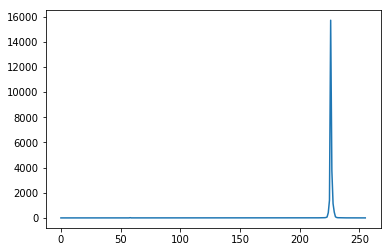

In [28]:
#plt.imshow(np.log(hmap[100:150,200:250]))
#hmap1d = hmap.reshape(256*256)
#plt.plot(hmap[128])
#print(np.max(hmap),np.min(hmap))
#hmap.shape
temp = hmap[100:150,200:250]
plt.plot(hmap[111])


In [38]:
t1 = datetime.datetime(2017,9,6,0,0)

imap = get_aia_image_sunpy(t1,94,256)

/Users/cpro/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


412.34651299036284

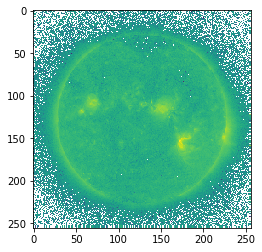

In [40]:
plt.imshow(np.log(np.flipud(imap)))
np.max(imap)

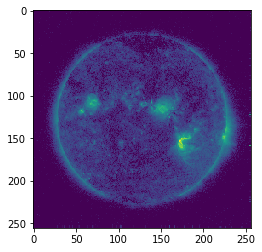

In [57]:
imap2 = np.where(imap<0.5,0.5,imap)
imap2 = np.flipud(imap2)
plt.imshow(np.log(imap2))

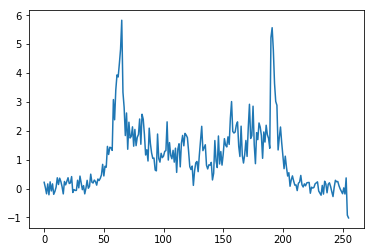

In [55]:
plt.plot(np.flipud(imap)[50])

In [20]:
hdulist[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 1024 / length of original image axis                  
NAXIS2  =                 1024 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
REQUESTI= 'Not_Used'                                                            
DATE    = '2017-09-15T00:58:38'                                                 
DATE-OBS= '2017-09-10T15:58:41.30'                                              
TELESCOP= 'SDO/HMI'                                                             
INSTRUME= 'HMI_COMBINED'    

In [1]:
from sunpy.net import Fido, attrs as a
results = Fido.search(a.Time("2012/1/1","2012/1/2"),a.Instrument('lyra'))

In [2]:
files = Fido.fetch(results)

[                                        =======================

In [3]:
from __future__ import print_function, division

import matplotlib.pyplot as plt

from sunpy.timeseries import TimeSeries
from sunpy.time import TimeRange, parse_time
from sunpy.net import hek, Fido, attrs as a

In [4]:
tr = TimeRange(['2011-06-07 04:00', '2011-06-07 12:00'])
results = Fido.search(a.Time(tr), a.Instrument('XRS'))

In [5]:
results

Start Time,End Time,Source,Instrument,Wavelength
str19,str19,str4,str4,str3
2011-06-07 00:00:00,2011-06-07 23:59:59,nasa,goes,nan


In [6]:
files = Fido.fetch(results)
goes = TimeSeries(files)

[                                        ======

In [7]:
client = hek.HEKClient()
flares_hek = client.search(hek.attrs.Time(tr.start, tr.end),\
                           hek.attrs.FL, hek.attrs.FRM.Name == 'SWPC')

/Users/cpro/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


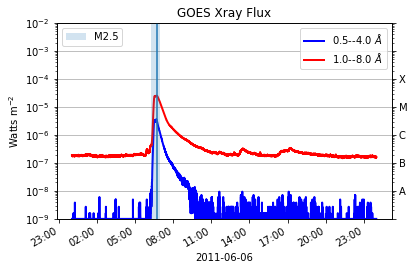

In [8]:
goes.peek()
plt.axvline(parse_time(flares_hek[0].get('event_peaktime')))
plt.axvspan(parse_time(flares_hek[0].get('event_starttime')),
            parse_time(flares_hek[0].get('event_endtime')),
            alpha=0.2, label=flares_hek[0].get('fl_goescls'))
plt.legend(loc=2)
plt.show()